# Demonstrate looking at sensitivity of LMP to stringency parameter

# Objective
Demonstrate tuning a one-parameter spot detection algorithm, Starfish's LocalMaxPeakFinder (LMP), using ground truth (in the form of expert annotations).

# Results
Clear optimum can be detected, using the same “maximize precision and recall” principle that’s used for parameter estimation in the pipeline as described in Section xx. LMP behaves for osmFISH, which is expected because LMP is shown for osmFISH in original starfish notebooks.

# Takeaway 
If using an algorithm that’s appropriate for the chemistry, ground truth is still essential for tuning parameters.

In [1]:
import os, warnings, pickle
from instapipeline import param

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from starfish import FieldOfView, data
from starfish.types import Axes
from starfish.spots import DetectSpots
from matplotlib.lines import Line2D

%matplotlib inline
%load_ext autoreload
%autoreload 2

/usr/local/lib/python3.6/site-packages/napari/__init__.py:27: UserWarning: 
    napari was tested with QT library `>=5.12.3`.
    The version installed is 5.12.2. Please report any issues with this
    specific QT version at https://github.com/Napari/napari/issues.
    
  warn(message=warn_message)


In [2]:
correctness_threshold = 10

In [3]:
experiment = data.osmFISH(use_test_data=True)
imgs = experiment["fov_000"].get_image(FieldOfView.PRIMARY_IMAGES)
print(imgs)

100%|██████████| 45/45 [00:12<00:00,  4.32it/s]

<starfish.ImageStack (r: 1, c: 1, z: 45, y: 2048, x: 2048)>


ghp filter

In [4]:
from starfish.image import Filter

filter_ghp = Filter.GaussianHighPass(sigma=(1,8,8), is_volume=True)
imgs_ghp = filter_ghp.run(imgs, in_place=False)

laplacian filter

In [5]:
filter_laplace = Filter.Laplace(sigma=(0.2, 0.5, 0.5), is_volume=True)
imgs_ghp_laplace = filter_laplace.run(imgs_ghp, in_place=False)

max projection over z

In [6]:
z_max_projector = Filter.Reduce((Axes.ZPLANE,))
mp = z_max_projector.run(imgs_ghp_laplace)

100%|██████████| 1/1 [00:00<00:00, 21.17it/s]


visualize data

100%|██████████| 1/1 [00:00<00:00, 66.28it/s]


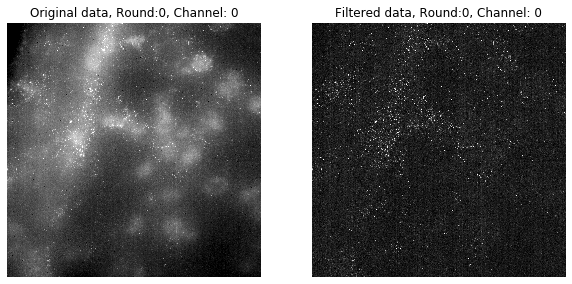

In [7]:
single_plane = imgs.max_proj(Axes.ZPLANE).xarray.sel({Axes.CH:0}).squeeze()
single_plane_filtered = mp.xarray.sel({Axes.CH: 0}).squeeze()

plt.figure(figsize=(10,10))
plt.subplot(121)
plt.imshow(single_plane, cmap='gray', clim = list(np.percentile(single_plane.data, [1, 99.9])))
plt.axis('off')
plt.title('Original data, Round:0, Channel: 0')
plt.subplot(122)
plt.imshow(single_plane_filtered, cmap='gray', clim = list(np.percentile(single_plane_filtered.data, [1, 99.9])))
plt.title('Filtered data, Round:0, Channel: 0')
plt.axis('off');

find spots, get intensities

In [8]:
stringencies = [-5, -4, 4, 5]

In [9]:
if not os.path.exists('./sens_data/'):
    os.mkdir('./sens_data/')

In [10]:
for stringency in stringencies:
    
    print(stringency)
    
    lmp = DetectSpots.LocalMaxPeakFinder(
        min_distance=6,
        stringency=stringency,
        min_obj_area=6,
        max_obj_area=600,
    )
    spot_intensities = lmp.run(mp)

    spots = spot_intensities[:, 0, 0].where(spot_intensities[:, 0, 0] != 0, drop=True)    
    x_vals = spots.x.values
    y_vals = spots.y.values

    blobs = []
    for x, y in zip(x_vals, y_vals):
        blobs.append([x, y])
    blobs = np.asarray(blobs)

    expert_path = 'filtered.csv'
    expert_coords = np.asarray(pd.read_csv(expert_path))
    precision, recall = param.get_precision_recall(
        test_coords=blobs, 
        ref_coords=expert_coords, 
        correctness_threshold=correctness_threshold)
    
    print(precision, recall)

    np.savetxt('./sens_data/blobs_%s.csv' % stringency, blobs)

-5


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:49<00:25,  1.69it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...
1.0 0.0006675567423230974
-4


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:32<00:24,  1.78it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...
1.0 0.0006675567423230974
4


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:32<00:24,  1.74it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...
0.9873417721518988 0.32710280373831774
5


  0%|          | 0/100 [00:00<?, ?it/s]

Determining optimal threshold ...


 57%|█████▋    | 57/100 [00:28<00:21,  1.98it/s]

Stopping early at threshold=0.07317454672672533. Number of spots fell below: 3
computing final spots ...
0.9937304075235109 0.22162883845126835


In [11]:
stringencies = [-5, -4, -3, -2, -1, 0, 1, 2, 3, 4, 5]

In [17]:
precision_list, recall_list = [], []
for stringency in stringencies:
    print(stringency)
    blobs_path = './sens_data/blobs_%s.csv' % stringency
    blobs = np.asarray(pd.read_csv(blobs_path, header=None))
    expert_path = 'filtered.csv'
    expert_coords = np.asarray(pd.read_csv(expert_path))
    precision, recall = param.get_precision_recall(
        test_coords=blobs, 
        ref_coords=expert_coords, 
        correctness_threshold=correctness_threshold)
    precision_list.append(precision)
    recall_list.append(recall)

-5
-4
-3
-2
-1
0
1
2
3
4
5


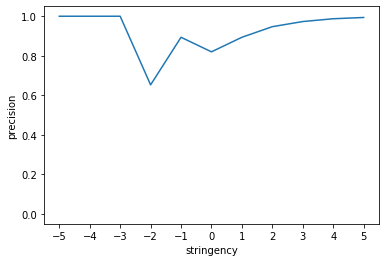

In [18]:
plt.plot(stringencies, precision_list)
plt.xlabel('stringency')
plt.ylabel('precision')
plt.ylim(-0.05, 1.05)
plt.xticks(np.arange(-5, 6, 1))
plt.show()

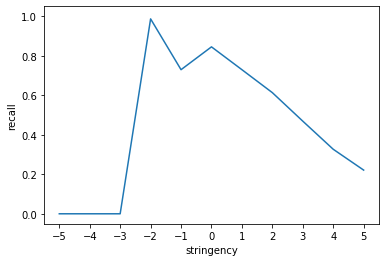

In [19]:
plt.plot(stringencies, recall_list)
plt.xlabel('stringency')
plt.ylabel('recall')
plt.ylim(-0.05, 1.05)
plt.xticks(np.arange(-5, 6, 1))
plt.show()

In [20]:
y = [a*b for a, b in zip(precision_list, recall_list)]

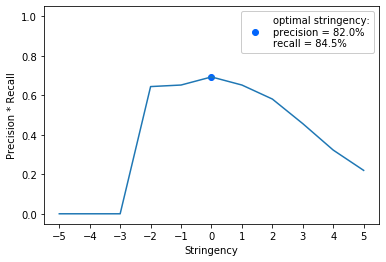

In [21]:
plt.plot(stringencies, y)
plt.scatter([stringencies[y.index(max(y))]], [max(y)], color='xkcd:bright blue')
plt.xlabel('Stringency')
plt.ylabel('Precision * Recall')
plt.xticks(np.arange(-5, 6, 1))
plt.ylim(-0.05, 1.05)

ind = y.index(max(y))

optimal_precision = 100*(round(precision_list[ind], 3))
optimal_recall = 100*(round(recall_list[ind], 3))

label_text = 'optimal stringency:\nprecision = %s%%\nrecall = %s%%' % (optimal_precision, optimal_recall)
leg_elem_1 = Line2D([0], [0], marker='o', markeredgecolor='xkcd:bright blue', markerfacecolor='xkcd:bright blue', color='None', label=label_text)
handle_list = [leg_elem_1]
plt.legend(handles=handle_list, loc='upper right', frameon=1, prop={'size':10}, framealpha=1)
plt.savefig('./sens_data/lmp_osmFISH.pdf', transparent=True, bbox_inches="tight")

plt.show()